# Capítulo 6 - Tarefas Continuadas - Differential Q-Learning


Você pode rodar este notebook localmente ou no Colab. Para abrir diretamente no Colab, basta clicar no link abaixo.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap06/cap06-main-2.ipynb)

## Configurações Iniciais

In [1]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install gym==0.23.1
    !pip install optuna

    # clone repository
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

clear_output()

In [2]:
import gym
from gym import spaces
import numpy as np
import optuna

from util.experiments import repeated_exec, repeated_exec_greedy_Q
from util.plot import plot_result, plot_multiple_results

d:\Pablo\anaconda3\envs\rlx\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1 - Tarefa Continuada (Infinita)

Uma **tarefa continuada** (*continuing task*) é uma tarefa representada por um MDP sem estado terminal (que pode ser chamado de *MDP continuado* ou *MDP de horizonte infinito*).

Existem várias críticas quanto à aplicação de algoritmos baseados em *retornos descontados* nestes ambientes, conforme o artigo *"Discounted Reinforcement Learning is Not an Optimization Problem"* (Naik et al., 2019).

O artigo citado propõe um MDP que ilustra as dificuldades de métodos como o *Q-Learning* e o *SARSA* em ambientes assim. O MDP pode ser ilustrado pela seguinte imagem (retirada do artigo):

<p align="center">
   <img src="https://github.com/pablo-sampaio/rl_facil/raw/main/cap06/two-choice-mdp-naik2019.jpg" alt="The Two-choice MDP (Naik et al., 2019)" width="500">
</p?>

Abaixo é dada a implementação `gym` do MDP proposto no artigo citado.

In [3]:
class TwoChoice(gym.Env):
    def __init__(self):
        super().__init__()

        # Define the action and observation spaces
        self.action_space = spaces.Discrete(2)  # Two discrete actions: 0 (left) and 1 (right)
        self.observation_space = spaces.Discrete(9)  # Nine discrete states: 0 to 8

    def reset(self):
        # Reset the environment to the initial state
        self.current_state = 0
        return self.current_state

    def step(self, action):
        # Perform the specified action and transition to the next state
        if action != 0 and action != 1:
            raise ValueError("Invalid action!")

        reward = 0.0

        if self.current_state == 0:
            # left
            if action == 0:
                reward = 1.0
                self.current_state = 1
            # right
            else:
                reward = 0.0
                self.current_state = 5
        elif self.current_state == 4:
            reward = 0.0
            self.current_state = 0
        elif self.current_state == 8:
            reward = 2.0
            self.current_state = 0
        else:
            reward = 0.0
            self.current_state += 1

        return self.current_state, reward, False, {}

    def render(self, mode=None):
        # Display the current state (optional)
        print("Current state:", self.current_state)


## 2 - Q-Learning (parando por passos)

Segue o mesmo **Q-learning** que vimos antes, porém com um critério de parada dado como uma quantidade de passos (não importa a quantidade de episódios envolvida).

In [4]:
# Esta é a política. Neste caso, escolhe uma ação com base nos valores
# da tabela Q, usando uma estratégia epsilon-greedy.
def epsilon_greedy(Q, state, num_actions, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(0, num_actions)
    else:
        return np.argmax(Q[state])

In [5]:
# Algoritmo Q-learning
def run_qlearning_step(env, total_steps, lr=0.1, gamma=0.95, epsilon=0.1):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q com zeros
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.zeros(shape = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    rewards_per_step = []

    state = env.reset()
    reward = 0

    # loop principal
    for i in range(total_steps):

        # escolhe a próxima ação -- usa epsilon-greedy
        action = epsilon_greedy(Q, state, num_actions, epsilon)

        # realiza a ação, ou seja, dá um passo no ambiente
        next_state, reward, done, _ = env.step(action)

        if done:
            # para estados terminais
            V_next_state = 0
            next_state = env.reset()
        else:
            # para estados não-terminais -- valor máximo (melhor ação)
            V_next_state = np.max(Q[next_state])

        # atualiza a Q-table
        # delta = (estimativa usando a nova recompensa) - estimativa antiga
        delta = (reward + gamma * V_next_state) - Q[state,action]
        Q[state,action] = Q[state,action] + lr * delta

        rewards_per_step.append(reward)

        state = next_state

        # a cada 1000 passos, imprime informação sobre o progresso
        if (i+1) % 1000 == 0:
            avg_reward = np.mean(rewards_per_step[-100:])
            print(f"Step {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return rewards_per_step, Q

In [6]:
TOTAL_STEPS = 100
LR = 0.3
GAMMA = 0.70   # só vai dar a política ótima para valores a partir de 0.85
EPSILON = 0.1

rmax = TOTAL_STEPS//2
env = TwoChoice()

rewards, qtable = run_qlearning_step(env, TOTAL_STEPS, LR, GAMMA, EPSILON)
print("Acumulado final =", sum(rewards))

Acumulado final = 22.0


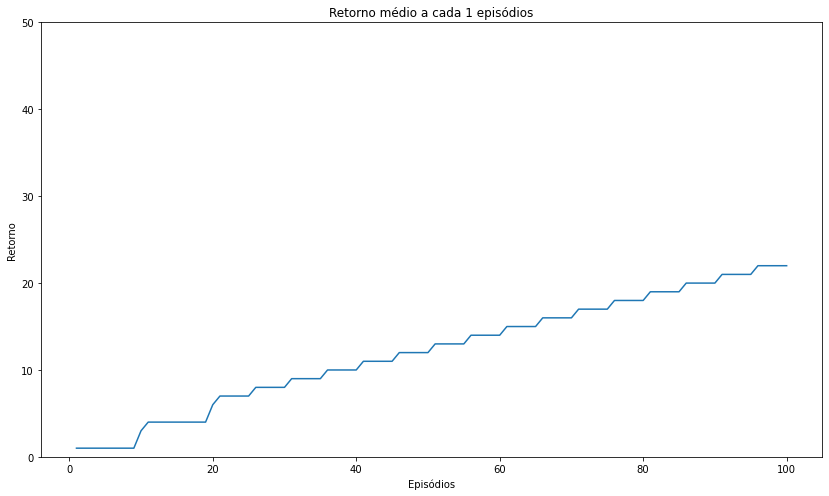

In [7]:
# Mostra um gráfico de passos x retornos não descontados acumulados
plot_result(rewards, rmax, cumulative=True, window=1)

## 3 - Differential Q-Learning

Um algoritmo específico para tarefas continuadas.

In [8]:
# Algoritmo Differential Q-learning
def run_differential_qlearning_step(env, total_steps, lr=0.1, eta=1.0, epsilon=0.1):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q com zeros
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.zeros(shape = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    rewards_per_step = []

    state = env.reset()
    reward = 0
    mean_reward = 0.0

    # loop principal
    for i in range(total_steps):

        # escolhe a próxima ação -- usa epsilon-greedy
        action = epsilon_greedy(Q, state, num_actions, epsilon)

        # realiza a ação, ou seja, dá um passo no ambiente
        next_state, reward, done, _ = env.step(action)

        assert not done, "This algorithm is for continuing tasks!"

        # para estados não-terminais -- valor máximo (melhor ação)
        V_next_state = np.max(Q[next_state])

        # atualiza a Q-table
        # delta = (estimativa usando a nova recompensa) - estimativa antiga
        delta = (reward - mean_reward + V_next_state) - Q[state,action]
        Q[state,action] = Q[state,action] + lr * delta

        # atualiza a recompensa média
        mean_reward += eta * lr * delta

        rewards_per_step.append(reward)
        state = next_state

        # a cada 1000 passos, imprime informação sobre o progresso
        if (i+1) % 1000 == 0:
            avg_reward = np.mean(rewards_per_step[-100:])
            print(f"Step {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return rewards_per_step, Q

In [9]:
TOTAL_STEPS = 100
LR = 0.3
ETA = 1.0
EPSILON = 0.1

rmax = TOTAL_STEPS//2
env = TwoChoice()

rewards, qtable = run_differential_qlearning_step(env, TOTAL_STEPS, LR, ETA, EPSILON)
print("Acumulado final =", (rewards[-1]))

Acumulado final = 0.0


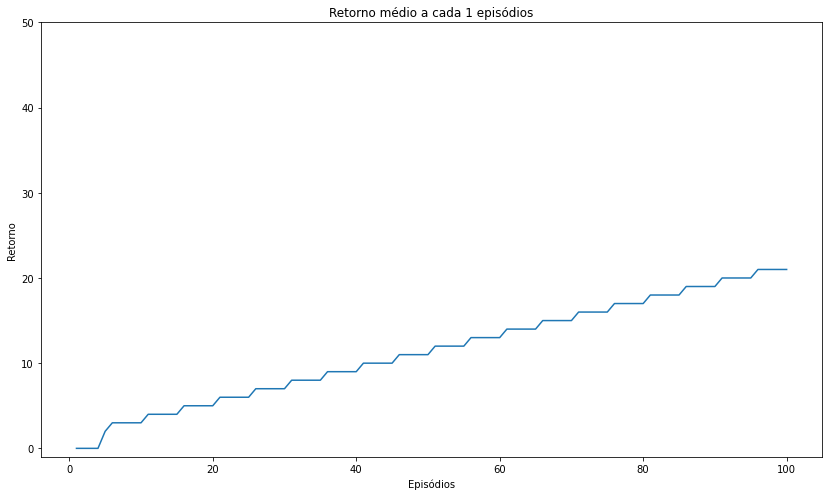

In [10]:
# Mostra um gráfico de passos x retornos não descontados acumulados
plot_result(rewards, rmax, cumulative=True, window=1)

## 4 - Otimizando Parâmetros

Vamos usar a biblioteca *Optuna* para otimizar (hiper-)parâmetros dos algoritmos de treinamento.

In [11]:
ENV   = TwoChoice()
RUNS_PER_TRIAL = 10

### 4.1 - Q-Learning

In [12]:
def create_train_fn(fixed_gamma):
    def train(trial : optuna.Trial):
        # chama os métodos do "trial" (tentativa) para sugerir valores para os parâmetros
        lr = trial.suggest_uniform('lr', 0.1, 1.0)
        eps = trial.suggest_uniform('epsilon', 0.01, 0.2)

        print(f"\nTRIAL #{trial.number}: lr={lr}, eps={eps}")

        # roda o algoritmo várias vezes
        results = repeated_exec(RUNS_PER_TRIAL, "qlearn-optuna", run_qlearning_step, ENV, 100, lr=lr, epsilon=eps, gamma=fixed_gamma)

        # soma dos retornos não-descontado finais
        return np.sum(results[1][:,-1])
    return train

In [13]:
GAMMA = 0.70
study = optuna.create_study(direction='maximize',
                        storage='sqlite:///optuna_continuing.db',
                        study_name=f'qlearning-g{GAMMA}',
                        load_if_exists=True)

study.optimize(create_train_fn(GAMMA), n_trials=100)
clear_output()

print("MELHORES PARÂMETROS PARA GAMMA", GAMMA, ":")
print(study.best_params)
qlearn_params_g07 = study.best_params
qlearn_params_g07['gamma'] = GAMMA

MELHORES PARÂMETROS PARA GAMMA 0.7 :
{'epsilon': 0.08939384035161647, 'lr': 0.36705421712333774}


In [14]:
GAMMA = 0.95
study = optuna.create_study(direction='maximize',
                        storage='sqlite:///optuna_continuing.db',
                        study_name=f'qlearning-g{GAMMA}',
                        load_if_exists=True)

study.optimize(create_train_fn(GAMMA), n_trials=100)
clear_output()

print("MELHORES PARÂMETROS PARA GAMMA", GAMMA, ":")
print(study.best_params)
qlearn_params_g09 = study.best_params
qlearn_params_g09['gamma'] = GAMMA

MELHORES PARÂMETROS PARA GAMMA 0.95 :
{'epsilon': 0.07220249843083883, 'lr': 0.5257999736673916}


### 4.2 - Differential Q-Learning

In [15]:
def train_diff(trial : optuna.Trial):
    # chama os métodos do "trial" (tentativa) para sugerir valores para os parâmetros
    lr = trial.suggest_uniform('lr', 0.1, 1.0)
    eps = trial.suggest_uniform('epsilon', 0.01, 0.20)
    eta = trial.suggest_uniform('eta', 0.1, 2.0)

    print(f"\nTRIAL #{trial.number}: lr={lr}, eps={eps}, eta={eta}")

    # roda o algoritmo várias vezes
    results = repeated_exec(RUNS_PER_TRIAL, "diff-q-optuna", run_differential_qlearning_step, ENV, 100, lr=lr, epsilon=eps, eta=eta)

    # soma dos retornos não-descontado finais
    return np.sum(results[1][:,-1])


In [16]:
study = optuna.create_study(direction='maximize',
                        storage='sqlite:///optuna_continuing.db',
                        study_name='diff-qlearning',
                        load_if_exists=True)

study.optimize(train_diff, n_trials=100)
clear_output()

print("MELHORES PARÂMETROS:")
print(study.best_params)
diff_qlearn_params = study.best_params

MELHORES PARÂMETROS:
{'epsilon': 0.19214783966218202, 'eta': 1.8741910896363185, 'lr': 0.8625876881576253}


## 5 - Experimentos

### 5.1 - Desempenho no Treinamento

Comparando os dois usando os parâmetros ótimos obtidos antes.

In [27]:
environment = TwoChoice()
NUM_STEPS = 200
RUNS = 200

results = []

results.append( repeated_exec(RUNS, f"Q-Learning (g=0.7)", run_qlearning_step, environment, NUM_STEPS, **qlearn_params_g07) )
clear_output()

results.append( repeated_exec(RUNS, f"Q-Learning (g=0.9)", run_qlearning_step, environment, NUM_STEPS, **qlearn_params_g09) )
clear_output()

results.append( repeated_exec(RUNS, f"Diff Q-Learning", run_differential_qlearning_step, environment, NUM_STEPS, **diff_qlearn_params) )
clear_output()

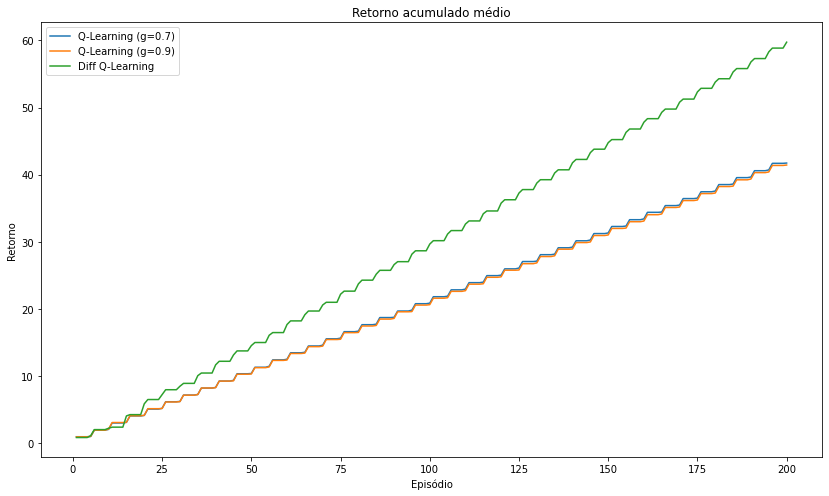

In [28]:
plot_multiple_results(results, cumulative='sum', window=1)

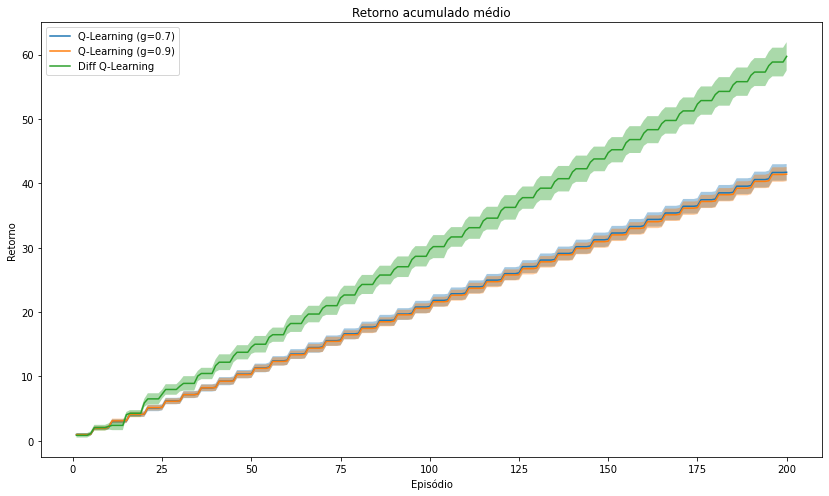

In [29]:
plot_multiple_results(results, cumulative='sum', window=1, plot_stddev=True)

In [ ]:
#index = 1
#plot_multiple_results(results[index:index+1], cumulative='sum', window=1, plot_stddev=True)

### 5.2 - Desempenho Pós-Treinamento

In [48]:
environment = TwoChoice()
NUM_STEPS = 1000

In [49]:
_, qtable1 = run_qlearning_step(environment, NUM_STEPS, **qlearn_params_g07)
#_, qtable2 = run_qlearning_step(environment, NUM_STEPS, **qlearn_params_g09)
_, qtable3 = run_differential_qlearning_step(environment, NUM_STEPS, **diff_qlearn_params)

Step 1000 Average Reward (last 100): 0.200
Step 1000 Average Reward (last 100): 0.300


In [50]:
results = []

results.append( repeated_exec_greedy_Q(1, "QLearn(0.7)-Greedy", qtable1, environment, 1000) )
#results.append( repeated_exec_greedy_Q(1, "QLearn(0.9)-Greedy", qtable2, environment, 1000) )
results.append( repeated_exec_greedy_Q(1, "Diff-QLearn-Greedy", qtable3, environment, 1000) )

Executing <function repeated_exec_greedy_Q.<locals>.run_q_greedy at 0x0000025F63D35160>:


100%|██████████| 1/1 [00:00<00:00, 182.58it/s]


  (1 executions of QLearn(0.7)-Greedy finished in 0.01 secs)
Executing <function repeated_exec_greedy_Q.<locals>.run_q_greedy at 0x0000025F63D35160>:


100%|██████████| 1/1 [00:00<00:00, 205.47it/s]

  (1 executions of Diff-QLearn-Greedy finished in 0.01 secs)


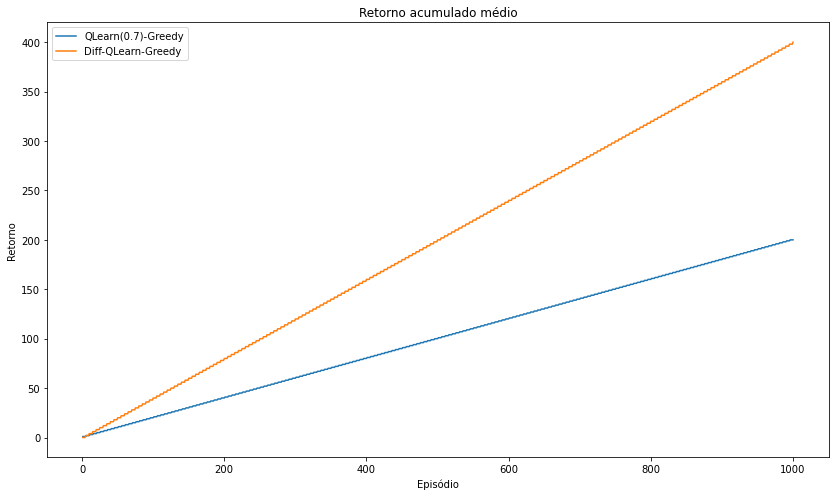

In [51]:
plot_multiple_results(results, cumulative='sum', window=1)